In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50, MobileNetV2, VGG16
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, BatchNormalization, MaxPooling2D, Activation, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint


import os
# Plotting and NumPy
import matplotlib.pyplot as plt
import numpy as np

# Visualkeras for model visualization
import visualkeras
from PIL import ImageFont 

In [ ]:
pip install visualkeras

In [11]:
# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5
NUM_CLASSES = 2

In [3]:
# Data preprocessing using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=20)
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'


In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Change this to your dataset directory
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    
)

test_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
 
)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Batch shape: (32, 224, 224, 3)


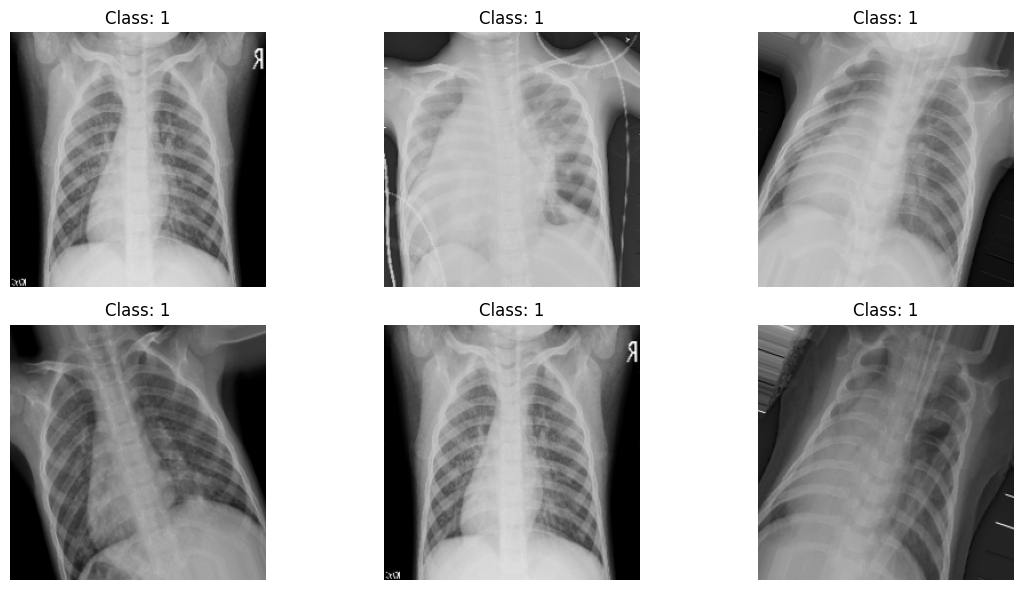

In [7]:
images, labels = next(train_generator)

# Check shape to debug
print("Batch shape:", images.shape)  # Should be (batch_size, 256, 256, 3)

# Plot images
plt.figure(figsize=(12, 6))
num_images = 6  # Number of images to display
for i in range(num_images):
    plt.subplot(2, 3, i+1)
    rand_idx = np.random.randint(0, len(images))
    plt.imshow(images[rand_idx])  # Ensure correct color order
    plt.axis("off")
    plt.title(f"Class: {np.argmax(labels[rand_idx])}")
plt.tight_layout()
plt.show()

In [10]:
input = Input(shape=(224, 224, 3))

# Load Base Model
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_tensor=input)
base_model_resnet.trainable = True # Freeze base layers

# Add Custom Layers
x_resnet = base_model_resnet.output
x_resnet = GlobalAveragePooling2D()(x_resnet)
x_resnet = Dropout(0.5)(x_resnet) # Add dropout layer (0.5 rate)
x_resnet = Dense(1024, activation='relu')(x_resnet)
x_resnet = Dropout(0.5)(x_resnet) # Add dropout layer (0.5 rate) # Optional intermediate layer
output_resnet = Dense(NUM_CLASSES, activation='softmax')(x_resnet)

# Create and Compile Model
model_resnet = Model(inputs=input, outputs=output_resnet)
model_resnet.compile(optimizer=Adam(learning_rate=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
model_resnet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 25,687,938 (97.99 MB)

 Trainable params: 25,634,818 (97.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


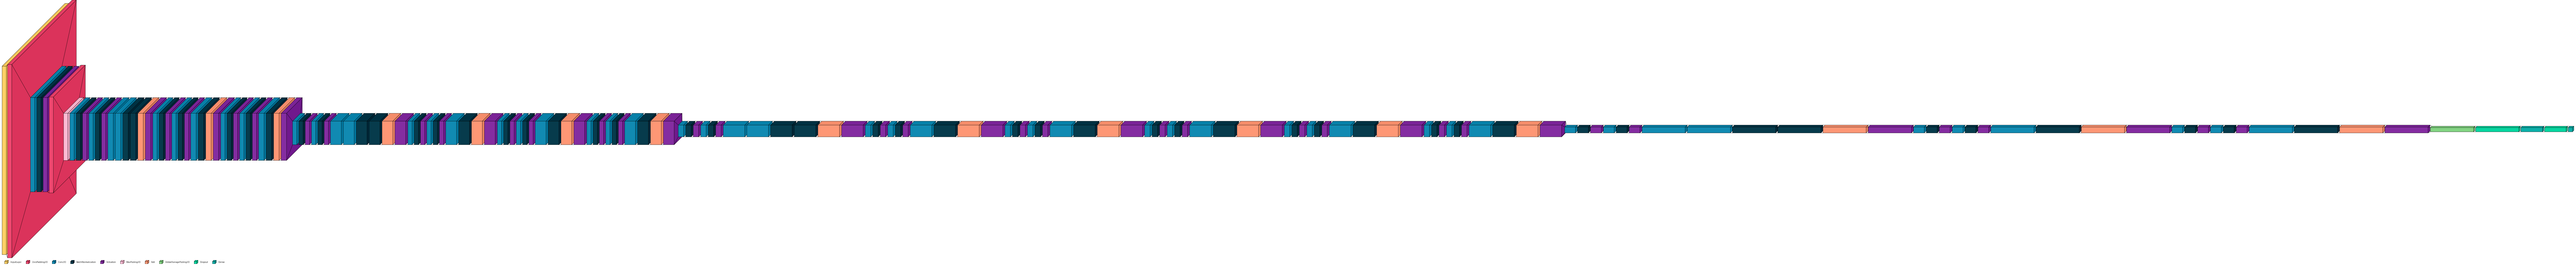

In [15]:
visualkeras.layered_view(model_resnet, legend=True)

In [14]:
checkpoint = ModelCheckpoint(
    'resnet_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

history_resnet = model_resnet.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    callbacks=[checkpoint]
)

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 762ms/step - accuracy: 0.9364 - loss: 0.2199
Epoch 1: val_accuracy improved from -inf to 0.37500, saving model to resnet_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 152s 902ms/step - accuracy: 0.9364 - loss: 0.2199 - val_accuracy: 0.3750 - val_loss: 10.6429
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.9494 - loss: 0.1863
Epoch 2: val_accuracy improved from 0.37500 to 0.62500, saving model to resnet_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 612ms/step - accuracy: 0.9494 - loss: 0.1861 - val_accuracy: 0.6250 - val_loss: 0.9006
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.9608 - loss: 0.1179
Epoch 3: val_accuracy did not improve from 0.62500
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 600ms/step - accuracy: 0.9608 - loss: 0.1179 - val_accuracy: 0.6250 - val_loss: 0.8762
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.9673 - loss: 0.1016
Epoch 4: val_accuracy did not improve from 0.62500
163/163

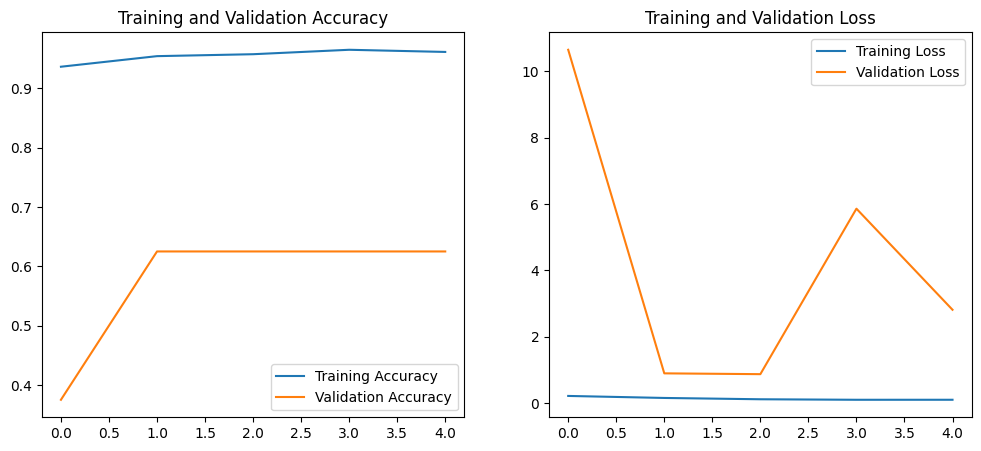

In [16]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Training Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [17]:
loss, accuracy = model_resnet.evaluate(test_generator)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 519ms/step - accuracy: 0.6140 - loss: 2.9307
Test Accuracy: 62.50%
Test Loss: 2.8230


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 666ms/step


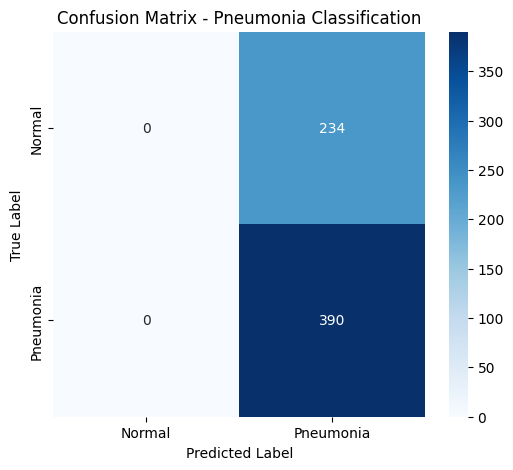

Classification Report:
               precision    recall  f1-score   support

      Normal       0.00      0.00      0.00       234
   Pneumonia       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: True Labels and Class Names
y_true = test_generator.classes  # True class indices
class_labels = ['Normal', 'Pneumonia']  # Make sure these match your actual class order

# Step 2: Get Predictions
y_pred_probs = model_resnet.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 3: Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Step 4: Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Pneumonia Classification')
plt.show()

# Step 5: Classification Report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)


In [19]:
input = Input(shape=(224, 224, 3))

# Load Base Model
base_model_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input)
base_model_mobilenet.trainable = False # Freeze base layers

# Add Custom Layers
x_mobilenet = base_model_mobilenet.output
x_mobilenet = GlobalAveragePooling2D()(x_mobilenet)
x_mobilenet = Dropout(0.5)(x_mobilenet) # Add dropout layer (0.5 rate)
x_mobilenet = Dense(1024, activation='relu')(x_mobilenet)
x_mobilenet = Dropout(0.5)(x_mobilenet) # Add dropout layer (0.5 rate) # Optional intermediate layer
output_mobilenet = Dense(NUM_CLASSES, activation='softmax')(x_mobilenet)

# Create and Compile Model
model_mobilenet = Model(inputs=input, outputs=output_mobilenet)
model_mobilenet.compile(optimizer=Adam(learning_rate=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
model_mobilenet.summary()

<ipython-input-19-50eedc74ea20>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 3,571,778 (13.63 MB)

 Trainable params: 1,313,794 (5.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


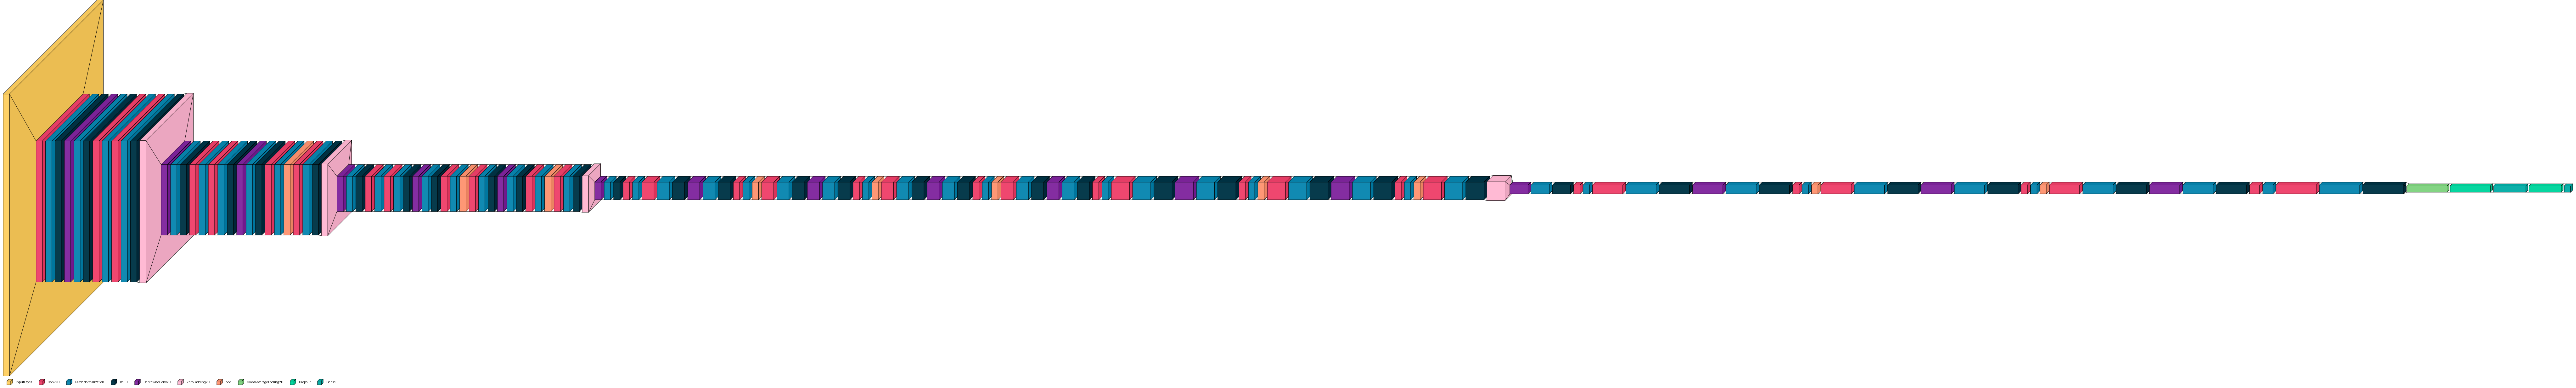

In [20]:
visualkeras.layered_view(model_mobilenet, legend=True)

In [22]:
checkpoint = ModelCheckpoint(
    'mobilenet_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

history_mobilenet = model_mobilenet.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    callbacks=[checkpoint]
)

Epoch 1/5
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.9400 - loss: 0.1555
Epoch 1: val_accuracy improved from -inf to 0.80609, saving model to mobilenet_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 618ms/step - accuracy: 0.9400 - loss: 0.1554 - val_accuracy: 0.8061 - val_loss: 0.4998
Epoch 2/5
161/163 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step - accuracy: 0.9399 - loss: 0.1387
Epoch 2: val_accuracy improved from 0.80609 to 0.82692, saving model to mobilenet_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 613ms/step - accuracy: 0.9399 - loss: 0.1387 - val_accuracy: 0.8269 - val_loss: 0.4672
Epoch 3/5
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.9350 - loss: 0.1510
Epoch 3: val_accuracy did not improve from 0.82692
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 613ms/step - accuracy: 0.9351 - loss: 0.1509 - val_accuracy: 0.7788 - val_loss: 0.6342
Epoch 4/5
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.9449 - loss: 0.1475
Epoch 4: val_accuracy did not improve from 0.82692
16

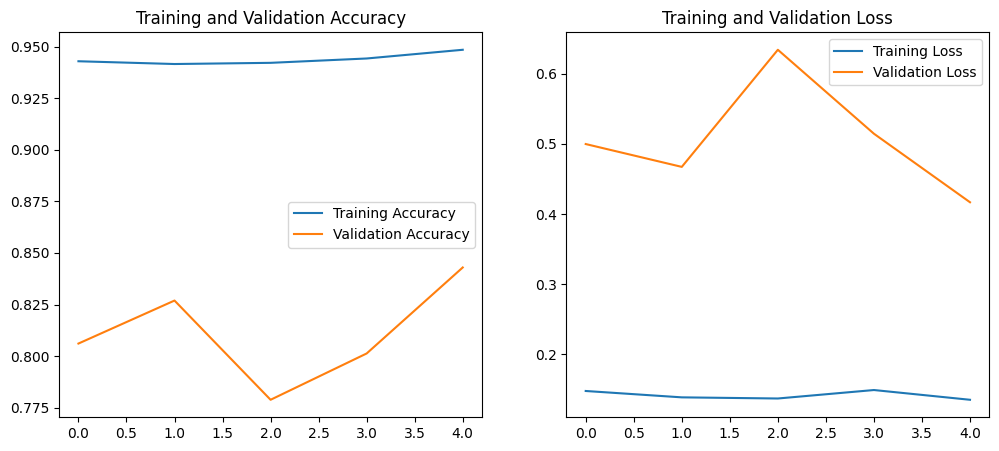

In [23]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_mobilenet.history['accuracy'], label='Training Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_mobilenet.history['loss'], label='Training Loss')
plt.plot(history_mobilenet.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [24]:
loss, accuracy = model_mobilenet.evaluate(test_generator)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 511ms/step - accuracy: 0.8325 - loss: 0.4386
Test Accuracy: 83.01%
Test Loss: 0.4554


20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 628ms/step


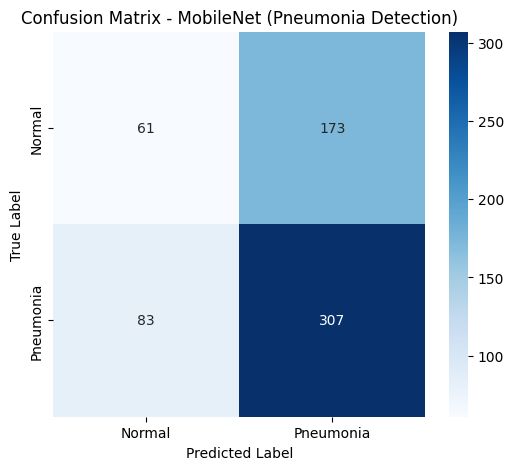

Classification Report:
               precision    recall  f1-score   support

      Normal       0.42      0.26      0.32       234
   Pneumonia       0.64      0.79      0.71       390

    accuracy                           0.59       624
   macro avg       0.53      0.52      0.51       624
weighted avg       0.56      0.59      0.56       624



In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: True Labels and Class Names
y_true = test_generator.classes  # True class indices
class_labels = ['Normal', 'Pneumonia']  # Ensure this matches your directory structure order

# Step 2: Get Predictions from MobileNet
y_pred_probs = model_mobilenet.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 3: Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Step 4: Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - MobileNet (Pneumonia Detection)')
plt.show()

# Step 5: Classification Report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)


In [40]:


model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

  # Binary classification output

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Model Summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_41 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_41               │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_43               │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_44               │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 10, 10, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (None, 10, 10, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 2)                   │             2

 Total params: 3,211,330 (12.25 MB)

 Trainable params: 3,209,346 (12.24 MB)

 Non-trainable params: 1,984 (7.75 KB)

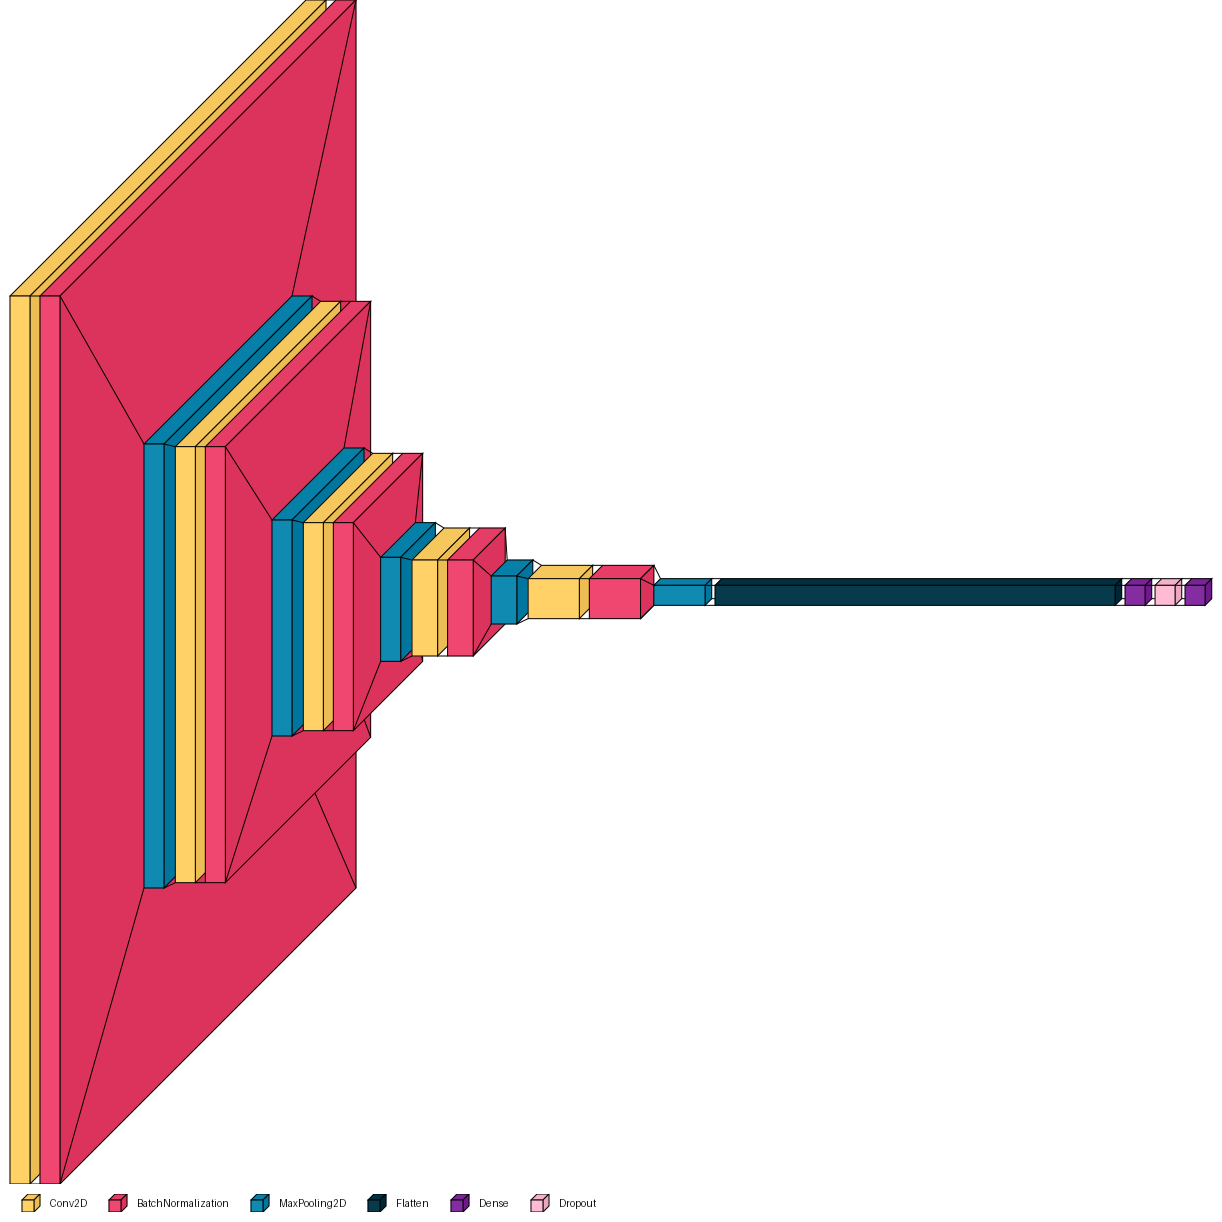

In [41]:
visualkeras.layered_view(model, legend=True)

In [42]:
checkpoint = ModelCheckpoint(
    'cnn_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

history_cnn = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    callbacks=[checkpoint]
)

Epoch 1/5
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.8570 - loss: 0.6353
Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to cnn_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 126s 694ms/step - accuracy: 0.8574 - loss: 0.6318 - val_accuracy: 0.6250 - val_loss: 56.6154
Epoch 2/5
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.9276 - loss: 0.2238
Epoch 2: val_accuracy did not improve from 0.62500
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 581ms/step - accuracy: 0.9277 - loss: 0.2234 - val_accuracy: 0.6250 - val_loss: 23.1880
Epoch 3/5
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.9516 - loss: 0.1599
Epoch 3: val_accuracy improved from 0.62500 to 0.62660, saving model to cnn_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 591ms/step - accuracy: 0.9514 - loss: 0.1602 - val_accuracy: 0.6266 - val_loss: 7.2575
Epoch 4/5
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.9474 - loss: 0.1495
Epoch 4: val_accuracy did not improve from 0.62660
163/163 ━━━━━

In [43]:
loss, accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 505ms/step - accuracy: 0.6079 - loss: 3.7447
Test Accuracy: 62.82%
Test Loss: 3.9649


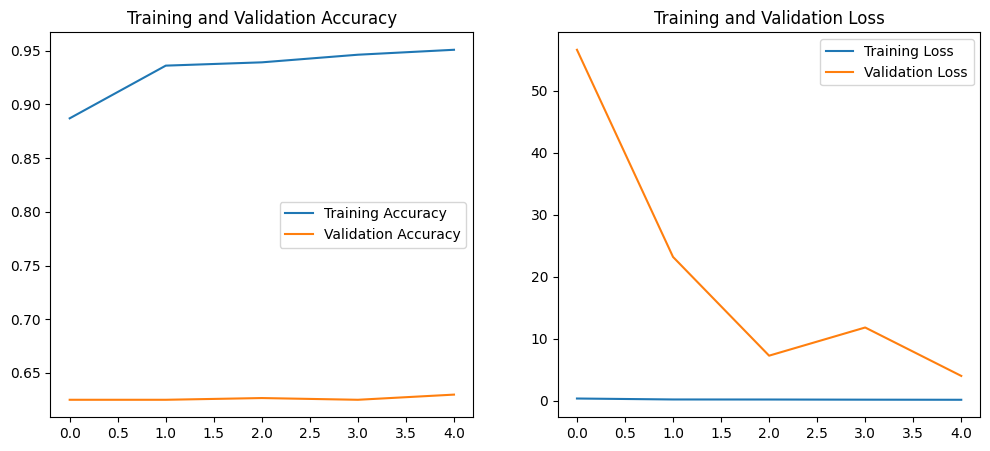

In [44]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 496ms/step


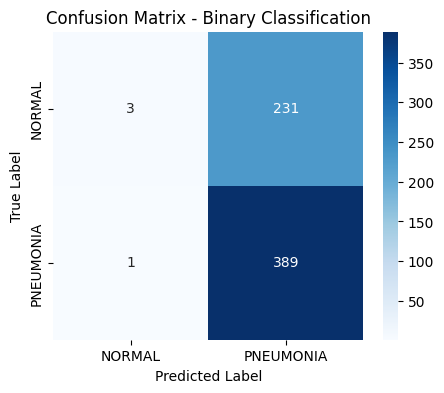

Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.75      0.01      0.03       234
   PNEUMONIA       0.63      1.00      0.77       390

    accuracy                           0.63       624
   macro avg       0.69      0.51      0.40       624
weighted avg       0.67      0.63      0.49       624



In [46]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: True labels and class names
y_true = test_generator.classes  # True class indices (e.g., 0 or 1)
class_labels = list(test_generator.class_indices.keys())  # ['ClassA', 'ClassB']

# Step 2: Get predictions
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 3: Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Step 4: Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Binary Classification')
plt.show()

# Step 5: Classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)


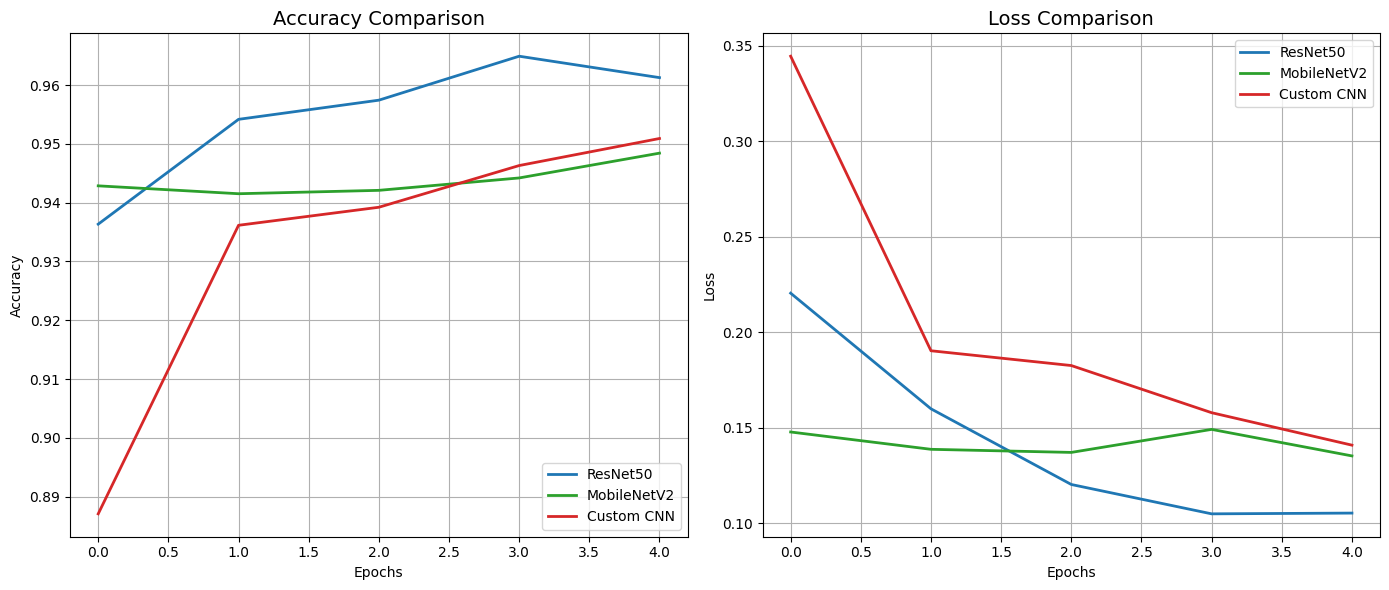

In [48]:
# Define colors for consistency
colors = {
    'ResNet50': '#1f77b4',       # Blue
    'MobileNetV2': '#2ca02c',    # Green
    'Custom CNN': '#d62728'      # Red
}

plt.figure(figsize=(14, 6))

# --- Validation Accuracy ---
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='ResNet50', color=colors['ResNet50'], linewidth=2)
plt.plot(history_mobilenet.history['accuracy'], label='MobileNetV2', color=colors['MobileNetV2'], linewidth=2)
plt.plot(history_cnn.history['accuracy'], label='Custom CNN', color=colors['Custom CNN'], linewidth=2)
plt.title('Accuracy Comparison', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# --- Validation Loss ---
plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='ResNet50', color=colors['ResNet50'], linewidth=2)
plt.plot(history_mobilenet.history['loss'], label='MobileNetV2', color=colors['MobileNetV2'], linewidth=2)
plt.plot(history_cnn.history['loss'], label='Custom CNN', color=colors['Custom CNN'], linewidth=2)
plt.title('Loss Comparison', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()